# Gaussian Prediction Experimental Analysis

This notebook will develop methods for the analysis and visualization of the gaussian action likelihood subgoal prediction method.

The experimental input data will be formatted according to mode 4 of the `DataLogger()` class (circa 03/12/17), and imported from `/simulator/data/`.

In [253]:
%matplotlib notebook
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import mat4py
import math

mpl.style.use('mitch-exp')

## Load data with pandas

In [254]:
pwd

u'/Users/mitchallain/Development/Python/BeagleBone-excavator/jupyter/CDC'

In [255]:
trialname = 'sim_0314_1447'
trial = pd.read_csv('../../simulator/data/' + trialname + '.csv')
trial.head()

,Time,Boom Cmd,Stick Cmd,Bucket Cmd,Swing Cmd,Boom Ctrl,Stick Ctrl,Bucket Ctrl,Swing Ctrl,Boom Blended,...,Bucket Ms,Swing Ms,SG0,SG1,SG2,SG3,SG4,SG5,Subgoal,Alpha
0,0.150873,0.0,0.0,-0.0,-0.0,-1.0,-1.0,-1.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,0.0
1,0.191096,0.0,0.0,-0.0,-0.0,-1.0,-1.0,-1.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,0.0
2,0.223857,0.0,0.0,-0.0,-0.0,-1.0,-1.0,-1.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,0.0
3,0.255483,0.0,0.0,-0.0,-0.0,-1.0,-1.0,-1.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,0.0
4,0.287705,0.0,0.0,-0.0,-0.0,-1.0,-1.0,-1.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,0.0


# Convert to end-effector space

Convert all measurements to end-effector space for later use.

In [256]:
ms = trial[['Boom Ms', 'Stick Ms', 'Bucket Ms', 'Swing Ms']].values
ms[:5]

array([[ 7.,  5.,  4.,  0.],
       [ 7.,  5.,  4.,  0.],
       [ 7.,  5.,  4.,  0.],
       [ 7.,  5.,  4.,  0.],
       [ 7.,  5.,  4.,  0.]])

In [257]:
def forward_kin_v(exc, sw, bm, sk, bk, bias=0):
    '''This func is the same as 'forward_kin' in this module but is easily vectorized.

    Note: ported to Python from MATLAB "fwd_kin.m", assumed options = [0, 0]

    Args:
        exc (dict): a dict of the excavator physical parameters
        sw (float): the swing angle
        bm (float): boom displacement in cm
        sk      ^^
        bk      ^^
        bias (float): positive z bias on output, to adjust weird base frame

    Returns:
        eef (list: float): the position of the end-effector (EEF) in (x, y, z - base frame) and the angle of the bucket (axis x4 w.r.t. x1(0?) ground axis)
    '''
    # Assign the base swing angle
    t1 = sw

    # Define lengths
    a1 = exc['a1']
    a2 = exc['a2']
    a3 = exc['a3']
    a4 = exc['a4']

    # Compute or Get joint angles
    # Boom angle
    r_c1 = bm + exc['r_cyl1']
    a_a1b = np.arccos((exc['r_o1b']**2 + exc['r_o1a']**2 - r_c1**2)/(2 * exc['r_o1b']*exc['r_o1a']))
    t2 = a_a1b - exc['a_b12'] - exc['a_a1x1']

    # Stick angle
    r_c2 = sk + exc['r_cyl2']
    a_c2d = np.arccos((exc['r_o2c']**2 + exc['r_o2d']**2 - r_c2**2)/(2 * exc['r_o2c'] * exc['r_o2d']))
    t3 = 3 * np.pi - exc['a_12c'] - a_c2d - exc['a_d23']

    # Bucket angle
    r_c3 = bk + exc['r_cyl3']
    a_efh = np.arccos((exc['r_ef']**2 + exc['r_fh']**2 - r_c3**2)/(2 * exc['r_ef'] * exc['r_fh']))
    a_hf3 = np.pi - exc['a_dfe'] - a_efh
    r_o3h = math.sqrt(exc['r_o3f']**2 + exc['r_fh']**2 - 2 * exc['r_o3f'] * exc['r_fh'] * np.cos(a_hf3))
    a_f3h = np.arccos((r_o3h**2 + exc['r_o3f']**2 - exc['r_fh']**2)/(2 * r_o3h * exc['r_o3f']))
    a_h3g = np.arccos((r_o3h**2 + exc['r_o3g']**2 - exc['r_gh']**2)/(2 * r_o3h * exc['r_o3g']))
    t4 = 3 * np.pi - a_f3h - a_h3g - exc['a_g34'] - exc['a_23d']

    c1 = np.cos(t1)
    c2 = np.cos(t2)
    c234 = np.cos(t2 + t3 + t4)
    c23 = np.cos(t2 + t3)
    s1 = np.sin(t1)
    s2 = np.sin(t2)
    s234 = np.sin(t2 + t3 + t4)
    s23 = np.sin(t2 + t3)

    P04 = np.array([[c1*(a4*c234+a3*c23+a2*c2+a1)],
                    [s1*(a4*c234+a3*c23+a2*c2+a1)],
                    [(a4*s234+a3*s23+a2*s2)],
                    [1]])

    # Bucket angle; angle between x4 and x0-y0 plane
    tb = t2 + t3 + t4 - 3 * np.pi

    # Position and orientation of the end effector
    eef = [axis.pop() for axis in P04[0:3].tolist()]
    assert eef
    eef.append(tb)

    return eef[0], eef[1], eef[2] + bias

In [258]:
forward_kin = np.vectorize(forward_kin_v)
exc = mat4py.loadmat('exc.mat')['exc']

In [259]:
ms_xyz = np.array(forward_kin(exc, ms[:, 3], ms[:, 0],
                              ms[:, 1], ms[:, 2], bias=17.1))

In [260]:
import pickle

Also, map subgoals to end-effector space

In [261]:
with open('gmm_model_exp.pkl', 'rb') as openfile:
    dists = pickle.load(openfile)
    means = dists['means']

mean_xyz = np.array(forward_kin(exc, means[:, 3], means[:, 0],
                              means[:, 1], means[:, 2], bias=17.1))

## Plot the samples and subgoals

Plot the samples with color corresponding to when the alpha threshold was reached.

In [262]:
set3 = plt.get_cmap('Set3').colors
alt = ['b', 'g', 'r', 'c', 'm', 'orange', 'grey']

In [263]:
from mpl_toolkits.mplot3d import Axes3D

In [264]:
# Indexes of active and subgoals when active

inactive = np.where(trial.Alpha == 0)
active = np.where(trial.Alpha != 0)
sgs = [np.where(trial.Subgoal == i) for i in range(len(means))]

# Set color labels
color = np.zeros(len(trial.Time))

for i, sg in enumerate(sgs):
    color[sg] = i
    
color[inactive] = -1

# Set size mapping
size = np.ones(len(trial.Time)) * 2
size[active] = (trial.Alpha.values[active] * 10) ** 2

In [265]:
def orient_plot(ax):
    ax.set_xlim3d([-20, 80])
    ax.set_ylim3d([0, 80])
    ax.set_zlim3d([0, 50])
    ax.view_init(azim=-142, elev=21)

<IPython.core.display.Javascript object>


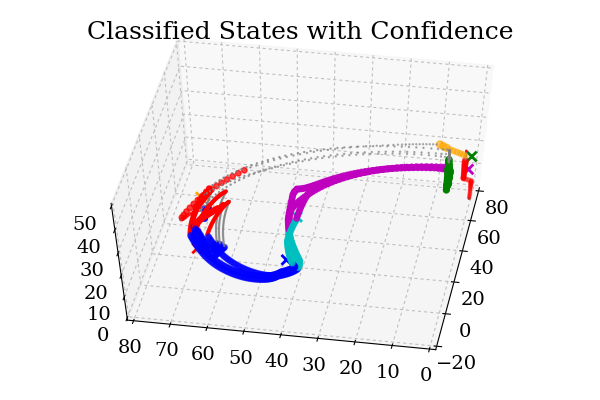

In [266]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(ms_xyz[0], ms_xyz[1], ms_xyz[2], zdir='z', 
           c=[alt[int(i)] for i in color], marker='.', s=size)


ax.scatter(mean_xyz[0], mean_xyz[1], mean_xyz[2], zdir='z', c=alt[:6],
           marker='x', alpha=1, s=50)

plt.title('Classified States with Confidence')
orient_plot(ax)
plt.tight_layout()

plt.savefig('figs/' + trialname + '.pdf', dpi=600)

## Assistance ratio

Assistance ratio defined as

`active time / total time`

In [267]:
np.count_nonzero(trial.Alpha) / float(len(trial.Alpha))

0.6734086853063652

In [268]:
error, = np.where(trial.Alpha > 1)
trial.Alpha[error]

104    1.006273
105    1.012667
Name: Alpha, dtype: float64